<a href="https://colab.research.google.com/github/germanKoch/nlp_course/blob/exercize/week05_transfer/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Homework 5: Question search engine

Remeber week01 where you used GloVe embeddings to find related questions? That was.. cute, but far from state of the art. It's time to really solve this task using context-aware embeddings.

__Warning:__ this task assumes you have seen `seminar.ipynb`!

In [1]:
%pip install --upgrade transformers datasets accelerate deepspeed
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import transformers
import datasets
import numpy as np

### Load data and model

In [2]:
qqp = datasets.load_dataset('SetFit/qqp')
print('\n')
print("Sample[0]:", qqp['train'][0])
print("Sample[3]:", qqp['train'][3])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")




Sample[0]: {'text1': 'How is the life of a math student? Could you describe your own experiences?', 'text2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0, 'label_text': 'not duplicate'}
Sample[3]: {'text1': 'What can one do after MBBS?', 'text2': 'What do i do after my MBBS ?', 'label': 1, 'idx': 3, 'label_text': 'duplicate'}


In [3]:
model_name = "gchhablani/bert-base-cased-finetuned-qqp"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Tokenize the data

In [ ]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

In [7]:
print(repr(qqp_preprocessed['train'][0]['input_ids'])[:100], "...")

[101, 1731, 1110, 1103, 1297, 1104, 170, 12523, 2377, 136, 7426, 1128, 5594, 1240, 1319, 5758, 136,  ...


### Task 1: evaluation (1 point)

We randomly chose a model trained on QQP - but is it any good?

One way to measure this is with validation accuracy - which is what you will implement next.

Here's the interface to help you do that:

In [8]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1, shuffle=False, collate_fn=transformers.default_data_collator
)

In [9]:
for batch in val_loader:
     break  # here be your training code
print("Sample batch:", batch)

with torch.no_grad():
  predicted = model(
      input_ids=batch['input_ids'],
      attention_mask=batch['attention_mask'],
      token_type_ids=batch['token_type_ids']
  )

print('\nPrediction (probs):', torch.softmax(predicted.logits, dim=1).data.numpy())

Sample batch: {'labels': tensor([0]), 'idx': tensor([0]), 'input_ids': tensor([[  101,  2009,  1132,  2170,   118,  4038,  1177,  2712,   136,   102,
          2009,  1132,  1117, 10224,  4724,  1177,  2712,   136,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,   

__Your task__ is to measure the validation accuracy of your model.
Doing so naively may take several hours. Please make sure you use the following optimizations:

- run the model on GPU with no_grad
- using batch size larger than 1
- use optimize data loader with num_workers > 1
- (optional) use [mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html)


In [12]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1024, shuffle=False, collate_fn=transformers.default_data_collator, num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
model = model.cuda()
labels = []
results = []


for batch in tqdm(val_loader):
  with torch.no_grad():
    predicted = model(
      input_ids=batch['input_ids'].cuda(),
      attention_mask=batch['attention_mask'].cuda(),
      token_type_ids=batch['token_type_ids'].cuda()
    )
    labels.append(batch['labels'].numpy())
    results.append(torch.softmax(predicted.logits, dim=1).cpu().numpy())

labels_np = np.concatenate(labels)
results_np = np.concatenate(results)
predicted_labels = results_np.argmax(axis=1)
accuracy = (predicted_labels == labels_np).sum() / len(predicted_labels)

100%|██████████| 40/40 [04:45<00:00,  7.13s/it]


In [41]:
assert 0.9 < accuracy < 0.91

### Task 2: train the model (4 points)

For this task, you have two options:

__Option A:__ fine-tune your own model. You are free to choose any model __except for the original BERT.__ We recommend [DeBERTa-v3](https://huggingface.co/microsoft/deberta-v3-base). Better yet, choose the best model based on public benchmarks (e.g. [GLUE](https://gluebenchmark.com/)).

You can write the training code manually or use transformers.Trainer (see [this example](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification)). Please make sure that your model's accuracy is at least __comparable__ with the above example for BERT.


__Option B:__ compare at least 3 pre-finetuned models (in addition to the above BERT model). For each model, report (1) its accuracy, (2) its speed, measured in samples per second in your hardware setup and (3) its size in megabytes. Please take care to compare models in equal setting, e.g. same CPU / GPU. Compile your results into a table and write a short (~half-page on top of a table) report, summarizing your findings.

In [23]:
model_name = "FacebookAI/roberta-base"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

Map:   0%|          | 0/390965 [00:00<?, ? examples/s]

In [5]:
torch.cuda.memory_allocated()

0

In [6]:
epochs = 1
train_set = qqp_preprocessed['train']
val_set = qqp_preprocessed['validation']

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=64, shuffle=True, collate_fn=transformers.default_data_collator, num_workers=2
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1024, shuffle=False, collate_fn=transformers.default_data_collator, num_workers=2
)

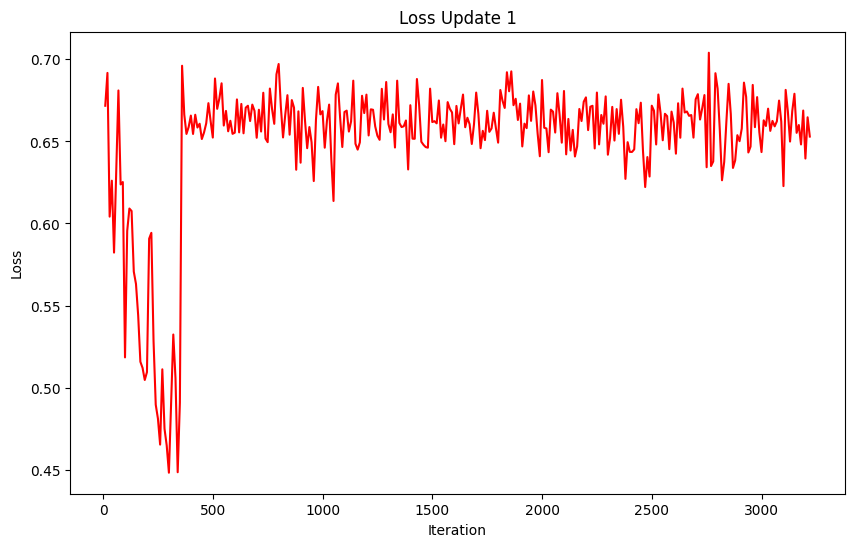

 28%|██▊       | 3221/11371 [36:20<1:34:15,  1.44it/s]

In [ ]:
# training loop
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import time

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss()

model = model.cuda()
loss_vals = {}
counter = 0

def show_plot(loss_vals):
    # Clear the previous figure
    clear_output(wait=True)

    # Plot the updated loss list
    plt.figure(figsize=(10, 6))
    plt.plot(loss_vals.keys(), loss_vals.values() , linestyle='-', color='r')
    plt.title(f'Loss Update {i+1}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    display(plt.gcf())
    # Close the plot to avoid redundant plots in the output
    plt.close()


def train_step(batch, model, optimizer, loss):
    optimizer.zero_grad()

    input_ids = batch['input_ids'].cuda()
    attention_mask = batch['attention_mask'].cuda()
    labels = batch['labels'].cuda()

    predicted = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    loss_val = loss(predicted.logits, labels)
    loss_val.backward()
    optimizer.step()

    del input_ids
    del attention_mask
    del labels

    return loss_val

for i in range(0, epochs):
    model.train()
    current_loss = []

    for batch in tqdm(train_loader):
        loss_val = train_step(batch, model, optimizer, loss)
        current_loss.append(loss_val.item())
        counter += 1

        if counter % 10 == 0:
          loss_vals[counter] = np.mean(current_loss)
          show_plot(loss_vals)
          current_loss = []

2.0

In [ ]:
model = model.cuda()
labels = []
results = []


for batch in tqdm(val_loader):
  with torch.no_grad():
    predicted = model(
      input_ids=batch['input_ids'].cuda(),
      attention_mask=batch['attention_mask'].cuda(),
      token_type_ids=batch['token_type_ids'].cuda()
    )
    labels.append(batch['labels'].numpy())
    results.append(torch.softmax(predicted.logits, dim=1).cpu().numpy())

labels_np = np.concatenate(labels)
results_np = np.concatenate(results)
predicted_labels = results_np.argmax(axis=1)
accuracy = (predicted_labels == labels_np).sum() / len(predicted_labels)

### Task 3: try the full pipeline (1 point)

Finally, it is time to use your model to find duplicate questions.
Please implement a function that takes a question and finds top-5 potential duplicates in the training set. For now, it is fine if your function is slow, as long as it yields correct results.

Showcase how your function works with at least 5 examples.

__Bonus:__ for bonus points, try to find a way to run the function faster than just passing over all questions in a loop. For isntance, you can form a short-list of potential candidates using a cheaper method, and then run your tranformer on that short list. If you opted for this solution, please keep both the original implementation and the optimized one - and explain briefly what is the difference there.